In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

import utils
from model.loss import *
import phate
import umap 
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
rna_dataset = symsim2_rna(counts_dir = "./data/symsim2/rand1/GxC1.txt", anno_dir = "./data/symsim2/rand1/cell_label1.txt")
atac_dataset = symsim2_atac(counts_dir = "./data/symsim2/rand1/RxC2.txt", anno_dir = "./data/symsim2/rand1/cell_label2.txt")

In [18]:
rna_CONFIG = { 
    'in_features': 1000,
    'layers': [512, 256, 64, 8], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

atac_CONFIG = { 
    'in_features': 3000,
    'layers': [512, 256, 64, 8], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_rna_loader = DataLoader(rna_dataset, batch_size = rna_CONFIG["minibatch_size"], shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = atac_CONFIG["minibatch_size"], shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)

for data in test_rna_loader:
    U_t1, Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    # X_umap1 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    # X_tsne1 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    X_phate1 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())
    U_t1 = torch.FloatTensor(U_t1)
    

for data in test_atac_loader:
    U_t2, Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 1e-3)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2)
    # X_umap2 = umap.UMAP(n_components=2).fit_transform(data["count"].numpy())
    # X_tsne2 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    X_phate2 = phate.PHATE(n_components=2).fit_transform(data["count"].numpy())

Calculating PHATE...
  Running PHATE on 1234 observations and 1000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.07 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.15 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.24 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 3.92 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.13 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.01 seconds.
Calculated PHATE in 6.30 seconds.
Calculating PHATE...
  Running PHATE on 1172 observations and 3000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.17 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.14 seconds.
    Calculating affinities...
  Calculated graph and diffusion op

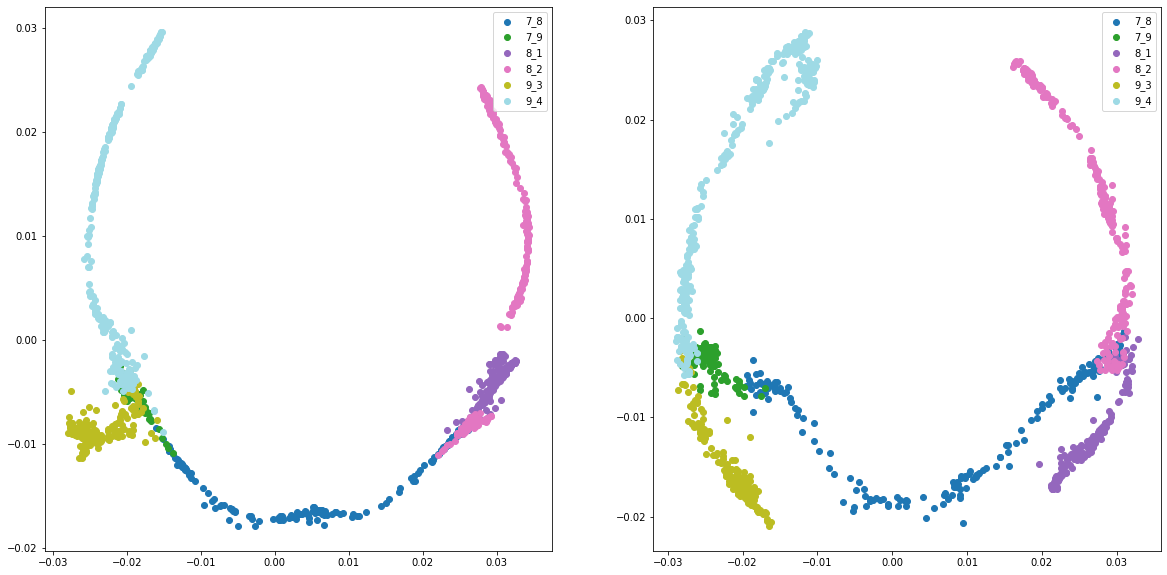

In [19]:
plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [20]:
encoder1 = ae.Encoder(rna_CONFIG)
encoder2 = ae.Encoder(atac_CONFIG)
fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 16, embed_channels = 2, activation = False, use_hidden = True)
decoder1 = ae.Decoder(rna_CONFIG)
decoder2 = ae.Decoder(atac_CONFIG)


optimizer_rna = torch.optim.Adam(list(encoder1.parameters()) + list(decoder1.parameters()), lr = 1e-4)
optimizer_atac = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr = 1e-4)
optimizer_dist_rna = torch.optim.Adam(list(encoder1.parameters()) + list(fusion.parameters()), lr = 5e-4)
optimizer_dist_atac = torch.optim.Adam(list(encoder2.parameters()) + list(fusion.parameters()), lr = 5e-4)

disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-4)

In [21]:
disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-4)

In [22]:
# add recon can help reduce the dist_loss
utils.pre_train_ae(encoder = encoder1, decoder = decoder1, fusion = fusion, data_loader = train_rna_loader, diff_sim = Diff1, recon_opt = optimizer_rna, dist_opt = optimizer_dist_rna, n_epochs = 101, lambda_r = 1, dist_mode = "mse")

epoch:  0 recon loss: 23.55440, dist loss: 0.28002
epoch:  10 recon loss: 3.71445, dist loss: 0.13283
epoch:  20 recon loss: 2.06008, dist loss: 0.11721
epoch:  30 recon loss: 1.48753, dist loss: 0.11615
epoch:  40 recon loss: 1.18124, dist loss: 0.11969
epoch:  50 recon loss: 0.98666, dist loss: 0.11444
epoch:  60 recon loss: 0.86264, dist loss: 0.11701
epoch:  70 recon loss: 0.76024, dist loss: 0.11699
epoch:  80 recon loss: 0.68224, dist loss: 0.13066
epoch:  90 recon loss: 0.62354, dist loss: 0.12046
epoch:  100 recon loss: 0.58618, dist loss: 0.11362


In [23]:
utils.pre_train_ae(encoder = encoder2, decoder = decoder2, fusion = fusion, data_loader = train_atac_loader, diff_sim = Diff2, recon_opt = optimizer_atac, dist_opt = optimizer_dist_atac,  n_epochs = 101, lambda_r = 1, dist_mode = "mse")

epoch:  0 recon loss: 0.57527, dist loss: 0.20359
epoch:  10 recon loss: 0.05577, dist loss: 0.11459
epoch:  20 recon loss: 0.03178, dist loss: 0.10705
epoch:  30 recon loss: 0.02513, dist loss: 0.11776
epoch:  40 recon loss: 0.02207, dist loss: 0.11638
epoch:  50 recon loss: 0.01806, dist loss: 0.11247
epoch:  60 recon loss: 0.01540, dist loss: 0.10683
epoch:  70 recon loss: 0.01461, dist loss: 0.10664
epoch:  80 recon loss: 0.01597, dist loss: 0.11491
epoch:  90 recon loss: 0.01411, dist loss: 0.10750
epoch:  100 recon loss: 0.01420, dist loss: 0.10736


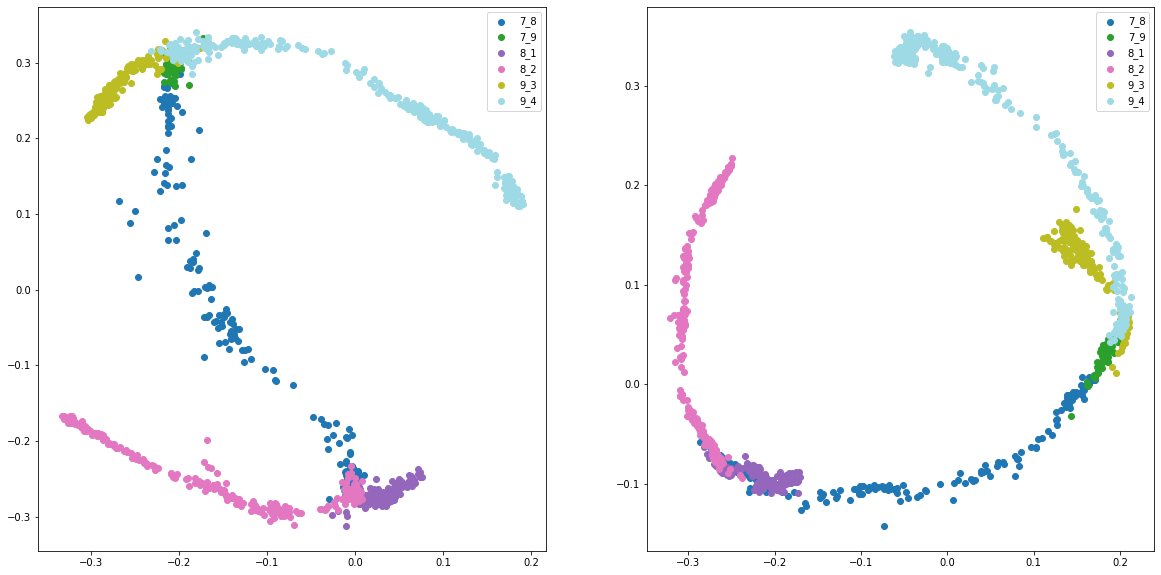

In [24]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [25]:
utils.pre_train_disc(encoder1 = encoder1, encoder2 = encoder2, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, disc_opt = optimizer_D, n_epochs = 201, use_anchor = False)

epoch:  0 Discriminator loss: 0.68294
epoch:  10 Discriminator loss: 0.66504
epoch:  20 Discriminator loss: 0.64539
epoch:  30 Discriminator loss: 0.62521
epoch:  40 Discriminator loss: 0.59608
epoch:  50 Discriminator loss: 0.56293
epoch:  60 Discriminator loss: 0.52222
epoch:  70 Discriminator loss: 0.47959
epoch:  80 Discriminator loss: 0.43173
epoch:  90 Discriminator loss: 0.39151
epoch:  100 Discriminator loss: 0.34606
epoch:  110 Discriminator loss: 0.29991
epoch:  120 Discriminator loss: 0.26552
epoch:  130 Discriminator loss: 0.22203
epoch:  140 Discriminator loss: 0.19801
epoch:  150 Discriminator loss: 0.16781
epoch:  160 Discriminator loss: 0.13483
epoch:  170 Discriminator loss: 0.12814
epoch:  180 Discriminator loss: 0.10535
epoch:  190 Discriminator loss: 0.09257
epoch:  200 Discriminator loss: 0.07499


In [26]:
# n_iter = 200 merge too good
utils.train_unpaired(encoder1 = encoder1, encoder2 = encoder2, decoder1 = decoder1, decoder2 = decoder2, fusion = fusion, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, disc_opt = optimizer_D, n_epochs=201, n_iter=200, n_iter2 = 15, lamb_r1 = 0, lamb_r2 = 0, lamb_disc=1, dist_mode = "mse", use_anchor = False)

epoch:  0 RNA recon loss: 0.00000, RNA dist loss: 0.11249 ATAC recon loss: 0.00000, ATAC dist loss: 0.14089 Discriminator loss: 0.22154
epoch:  10 RNA recon loss: 0.00000, RNA dist loss: 0.12580 ATAC recon loss: 0.00000, ATAC dist loss: 0.12174 Discriminator loss: 0.65697
epoch:  20 RNA recon loss: 0.00000, RNA dist loss: 0.11228 ATAC recon loss: 0.00000, ATAC dist loss: 0.11740 Discriminator loss: 0.33945
epoch:  30 RNA recon loss: 0.00000, RNA dist loss: 0.11432 ATAC recon loss: 0.00000, ATAC dist loss: 0.13056 Discriminator loss: 0.36792
epoch:  40 RNA recon loss: 0.00000, RNA dist loss: 0.11366 ATAC recon loss: 0.00000, ATAC dist loss: 0.13315 Discriminator loss: 0.34156
epoch:  50 RNA recon loss: 0.00000, RNA dist loss: 0.12132 ATAC recon loss: 0.00000, ATAC dist loss: 0.12530 Discriminator loss: 0.36937
epoch:  60 RNA recon loss: 0.00000, RNA dist loss: 0.11600 ATAC recon loss: 0.00000, ATAC dist loss: 0.12580 Discriminator loss: 0.22152
epoch:  70 RNA recon loss: 0.00000, RNA di

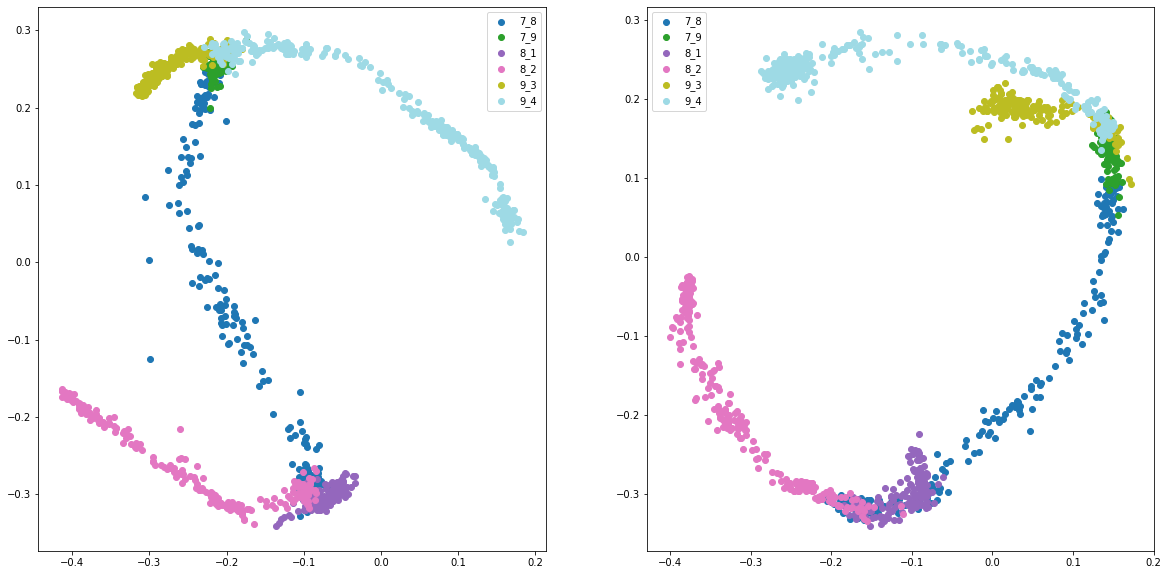

In [27]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

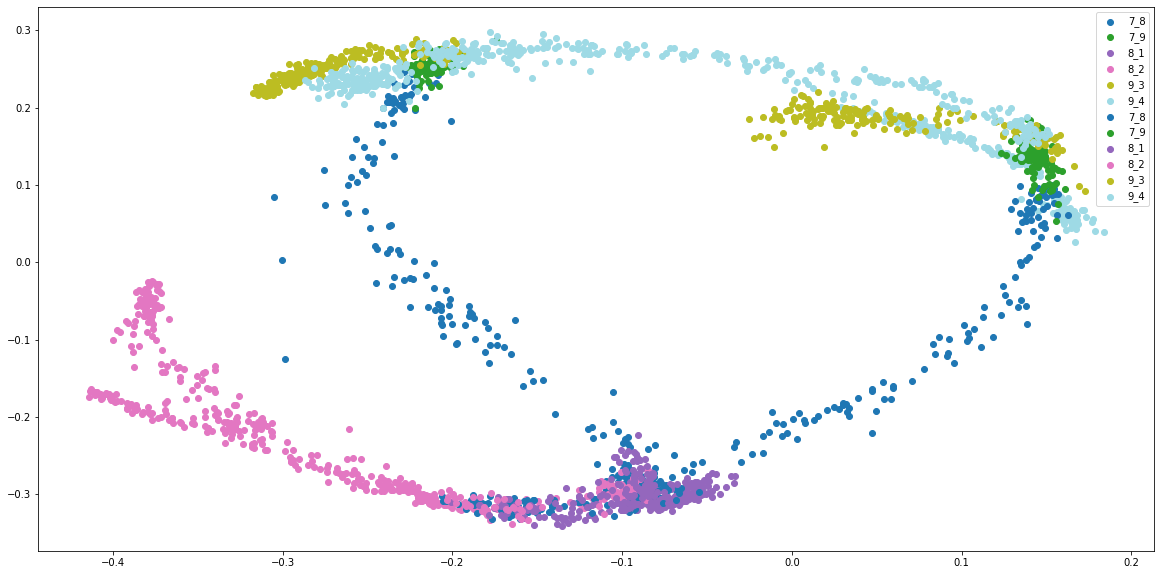

In [28]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "joint",save = None)

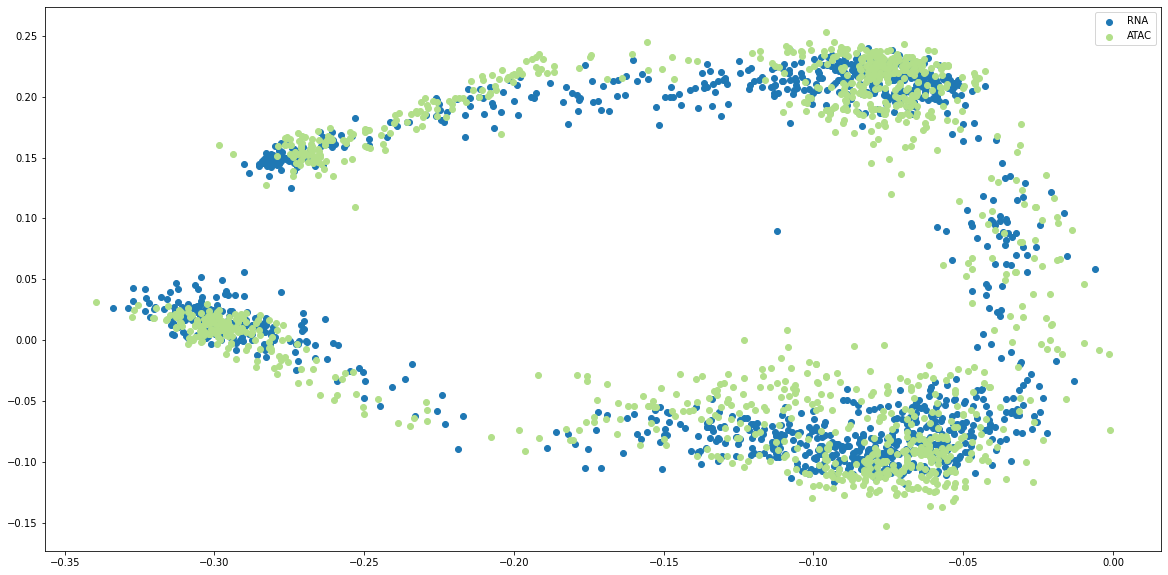

In [14]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "modality",save = None)

In [15]:
torch.save({
    'encoder1': encoder1.state_dict(),
    'encoder2': encoder2.state_dict(),
    'disc': disc.state_dict(),
    'fusion': fusion.state_dict(),
    'decoder1': decoder1.state_dict(),
    'decoder2': decoder2.state_dict(),
    'config1': rna_CONFIG,
    'config2': atac_CONFIG,
    'Diff1': Diff1,
    'Diff2': Diff2
}, './saved_model/symsim2.pt')

In [ ]:
# state = torch.load('./saved_model/symsim2.pt')

# encoder1 = ae.Encoder(rna_CONFIG).to(device)
# encoder1.load_state_dict(state['encoder1'])

# encoder2 = ae.Encoder(atac_CONFIG).to(device)
# encoder2.load_state_dict(state['encoder2'])

# fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 2, embed_channels = 2, activation = False, use_hidden = False)
# fusion.load_state_dict(state['fusion'])

# decoder1 = ae.Decoder(rna_CONFIG).to(device)
# decoder1.load_state_dict(state['decoder1'])

# decoder2 = ae.Decoder(atac_CONFIG).to(device)
# decoder2.load_state_dict(state['decoder2'])

# disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
# disc.load_state_dict(state['disc'])